# 256 20 epochs model

## Setup

In [ ]:
import tensorflow as tf
import os
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

## Load Data

In [ ]:
!unzip /content/drive/MyDrive/ComputerVision/asl_dataset.zip

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

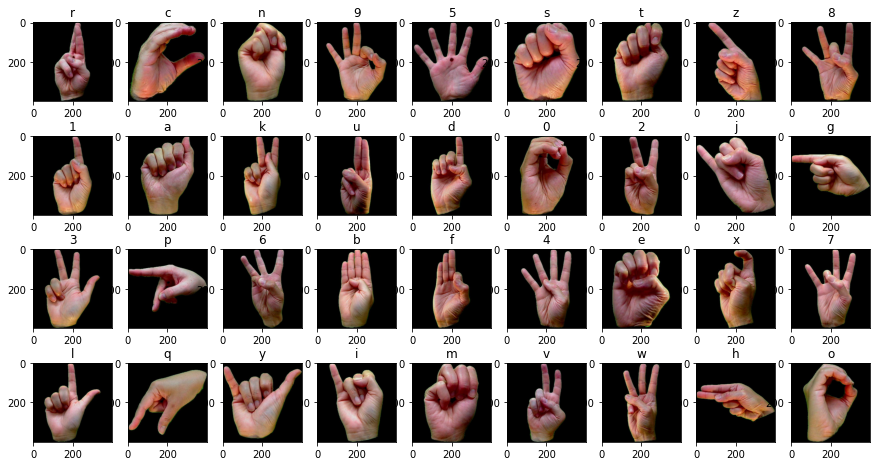

In [ ]:
fig, ax = plt.subplots(4, 9, figsize=(15,8))
labels = [os.path.join('/content/asl_dataset', label) for label in os.listdir('/content/asl_dataset')]
ax = ax.flatten()
for i, label in enumerate(labels):
    img = os.listdir(label)[np.random.randint(0, 10)]
    path = os.path.join(label, img)
    image = cv2.imread(path)
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].set_title(os.path.basename(label))
plt.show()

In [ ]:
from PIL import Image
from tensorflow.keras.utils import img_to_array, array_to_img

In [ ]:
images = []
labels = []
for label in os.listdir('/content/asl_dataset'):
    for file in os.listdir(f"/content/asl_dataset/{label}"):
        path = f"/content/asl_dataset/{label}/{file}"
        image = Image.open(path)
        image = image.resize((256,256))
        image = img_to_array(image)
        images.append(image)
        labels.append(label)

## Split Train-Test Data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state = 666)

## Scale Data

In [ ]:
X_train = np.array(X_train, dtype=np.float16) / 255.0
X_test = np.array(X_test, dtype=np.float16) / 255.0
X_train = X_train.reshape( -1, 256,256,3)
X_test = X_test.reshape( -1, 256,256,3)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

In [ ]:
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

## Split Train-Validate Data

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=666)

## Build CNN Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(256, 256, 3),activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(36, activation='softmax'))
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 32)      

In [ ]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(X_train, y_train, batch_size = 32, epochs = 20, validation_data=(X_val,y_val), callbacks=[tensorboard_callback])

## Visualize Training Result

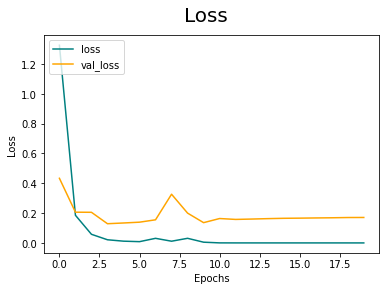

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

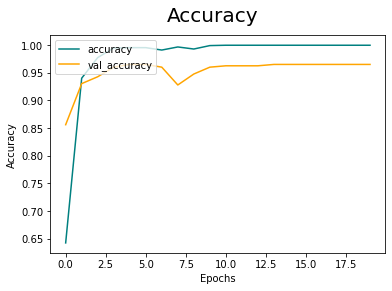

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

## Evaluate Model

In [ ]:
model.evaluate(X_test, y_test)

16/16 [==============================] - 20s 1s/step - loss: 0.2269 - accuracy: 0.9503


[0.2269117385149002, 0.9502981901168823]

In [ ]:
y_pred = model.predict(X_test)

16/16 [==============================] - 19s 1s/step


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

In [ ]:
y_pred = lb.inverse_transform(y_pred)

In [ ]:
y_test = lb.inverse_transform(y_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.9284294234592445

Text(0.5, 1.0, 'Accuracy Score: 0.9284294234592445')

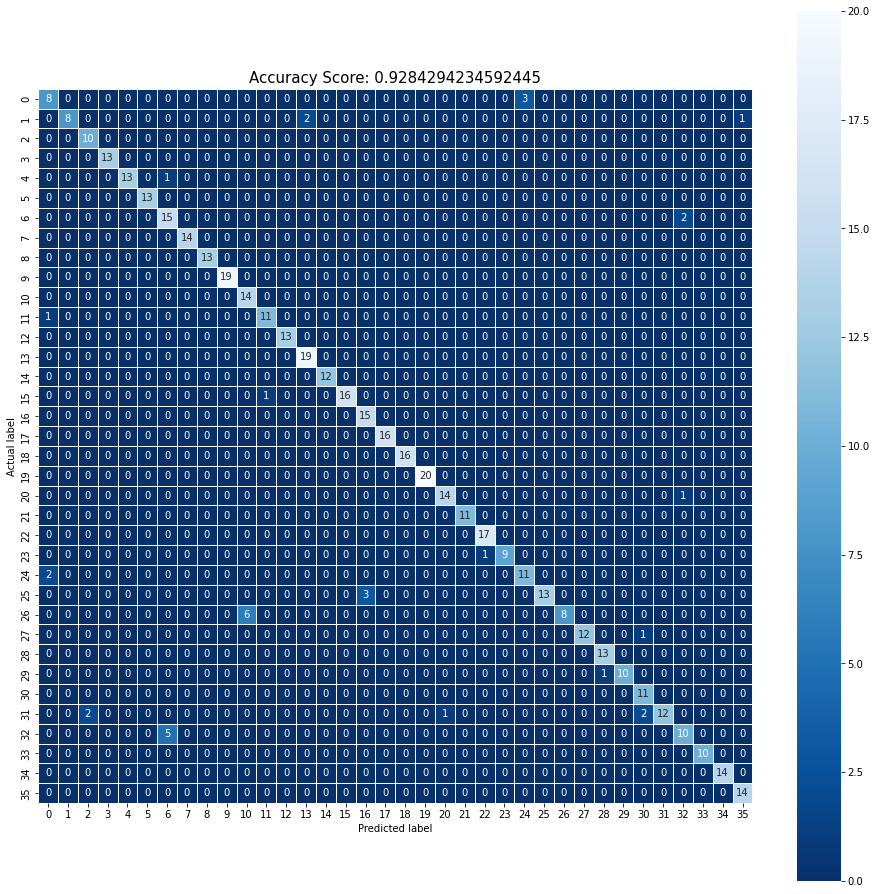

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16,16))
sns.heatmap(cm,annot=True, fmt='.0f', linewidths=.5, square=True,cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test, y_pred))
plt.title(all_sample_title,size=15)

In [ ]:
model.save("/content/drive/MyDrive/ComputerVision/ModelOriginal")

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/ComputerVision/ModelOriginal")

In [ ]:
img = Image.open("/content/asl_dataset/5/hand1_5_right_seg_1_cropped.jpeg")
img = img.resize((256,256))
img = img_to_array(img)
img = np.array(img, dtype=np.float16) / 225.0
img = img.reshape( -1, 256,256,3)

In [ ]:
pred = model.predict(img)

1/1 [==============================] - 0s 56ms/step


In [ ]:
out = lb.inverse_transform(pred)
print(out)

['5']


# Grayscale

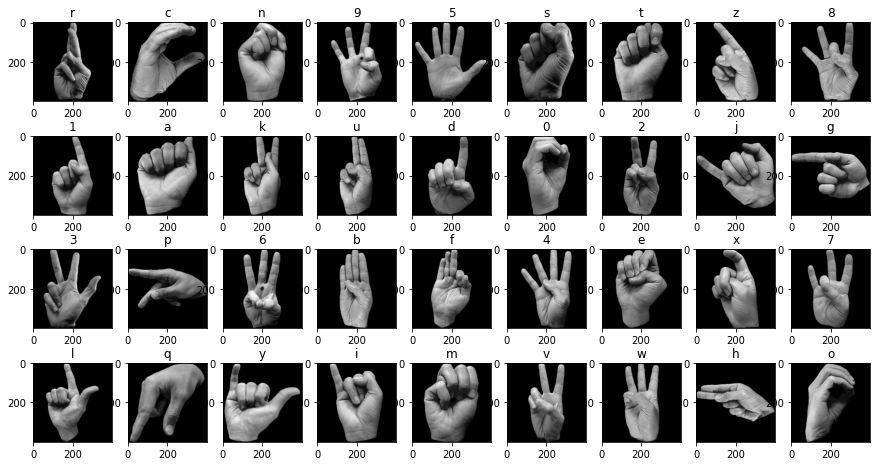

In [ ]:
fig, ax = plt.subplots(4, 9, figsize=(15,8))
labels = [os.path.join('/content/asl_dataset', label) for label in os.listdir('/content/asl_dataset')]
ax = ax.flatten()
for i, label in enumerate(labels):
    img = os.listdir(label)[np.random.randint(0, 10)]
    path = os.path.join(label, img)
    image = cv2.imread(path)
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), cmap="gray")
    ax[i].set_title(os.path.basename(label))
plt.show()

In [ ]:
images = []
labels = []
for label in os.listdir('/content/asl_dataset'):
    for file in os.listdir(f"/content/asl_dataset/{label}"):
        path = f"/content/asl_dataset/{label}/{file}"
        image = Image.open(path)
        image2 = image.rotate(36)
        image3 = image.rotate(72)
        image4 = image.rotate(108)
        image5 = image.rotate(144)
        image = image.convert('L')
        image2 = image.convert('L')
        image3 = image.convert('L')
        image4 = image.convert('L')
        image5 = image.convert('L')
        image = image.resize((256,256))
        image2 = image.resize((256,256))
        image3 = image.resize((256,256))
        image4 = image.resize((256,256))
        image5 = image.resize((256,256))
        image = img_to_array(image)
        image2 = img_to_array(image2)
        image3 = img_to_array(image3)
        image4 = img_to_array(image4)
        image5 = img_to_array(image5)
        images.append(image)
        images.append(image2)
        images.append(image3)
        images.append(image4)
        images.append(image5)
        labels.append(label)
        labels.append(label)
        labels.append(label)
        labels.append(label)
        labels.append(label)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state = 666)

In [ ]:
X_train = np.array(X_train, dtype=np.float16) / 255.0
X_test = np.array(X_test, dtype=np.float16) / 255.0
X_train = X_train.reshape( -1, 256,256,1)
X_test = X_test.reshape( -1, 256,256,1)

In [ ]:
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=666)

In [ ]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 1), padding='same', input_shape=(256, 256, 1),activation='relu'))
model2.add(MaxPooling2D())
model2.add(Conv2D(64, (3, 1), padding='same', activation='relu'))
model2.add(MaxPooling2D())
model2.add(Conv2D(32, (3, 1), padding='same', activation='relu'))
model2.add(MaxPooling2D())
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(36, activation='softmax'))
model2.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      128       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      6208      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        6176      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0

In [ ]:
hist2 = model2.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_data=(X_val,y_val), callbacks=[tensorboard_callback])

Epoch 1/10
252/252 [==============================] - 410s 2s/step - loss: 0.4313 - accuracy: 0.8796 - val_loss: 0.0514 - val_accuracy: 0.9851
Epoch 2/10
252/252 [==============================] - 403s 2s/step - loss: 0.0203 - accuracy: 0.9934 - val_loss: 0.0154 - val_accuracy: 0.9950
Epoch 3/10
252/252 [==============================] - 425s 2s/step - loss: 0.0047 - accuracy: 0.9989 - val_loss: 0.0065 - val_accuracy: 0.9970
Epoch 4/10
252/252 [==============================] - 412s 2s/step - loss: 4.8700e-04 - accuracy: 1.0000 - val_loss: 7.3632e-04 - val_accuracy: 1.0000
Epoch 5/10
252/252 [==============================] - 418s 2s/step - loss: 6.4043e-05 - accuracy: 1.0000 - val_loss: 5.5244e-04 - val_accuracy: 1.0000
Epoch 6/10
252/252 [==============================] - 424s 2s/step - loss: 3.6430e-05 - accuracy: 1.0000 - val_loss: 3.8180e-04 - val_accuracy: 1.0000
Epoch 7/10
252/252 [==============================] - 433s 2s/step - loss: 2.3807e-05 - accuracy: 1.0000 - val_loss: 3

In [ ]:
model2.save("/content/drive/MyDrive/ComputerVision/ModelGrayScale")

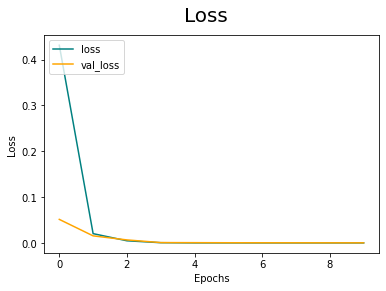

In [ ]:
fig = plt.figure()
plt.plot(hist2.history['loss'], color='teal', label='loss')
plt.plot(hist2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

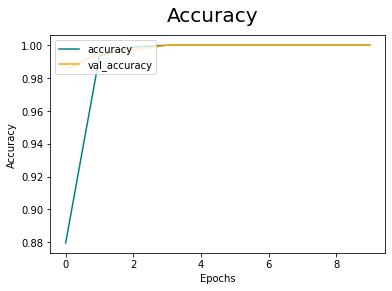

In [ ]:
fig = plt.figure()
plt.plot(hist2.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist2.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

In [ ]:
model2.evaluate(X_test, y_test)

16/16 [==============================] - 12s 767ms/step - loss: 0.1814 - accuracy: 0.9602


[0.18135957419872284, 0.9602385759353638]

In [ ]:
y_pred = model2.predict(X_test)
y_pred = lb.inverse_transform(y_pred)
y_test = lb.inverse_transform(y_test)
accuracy_score(y_test, y_pred)

79/79 [==============================] - 59s 743ms/step


1.0

Text(0.5, 1.0, 'Accuracy Score: 1.0')

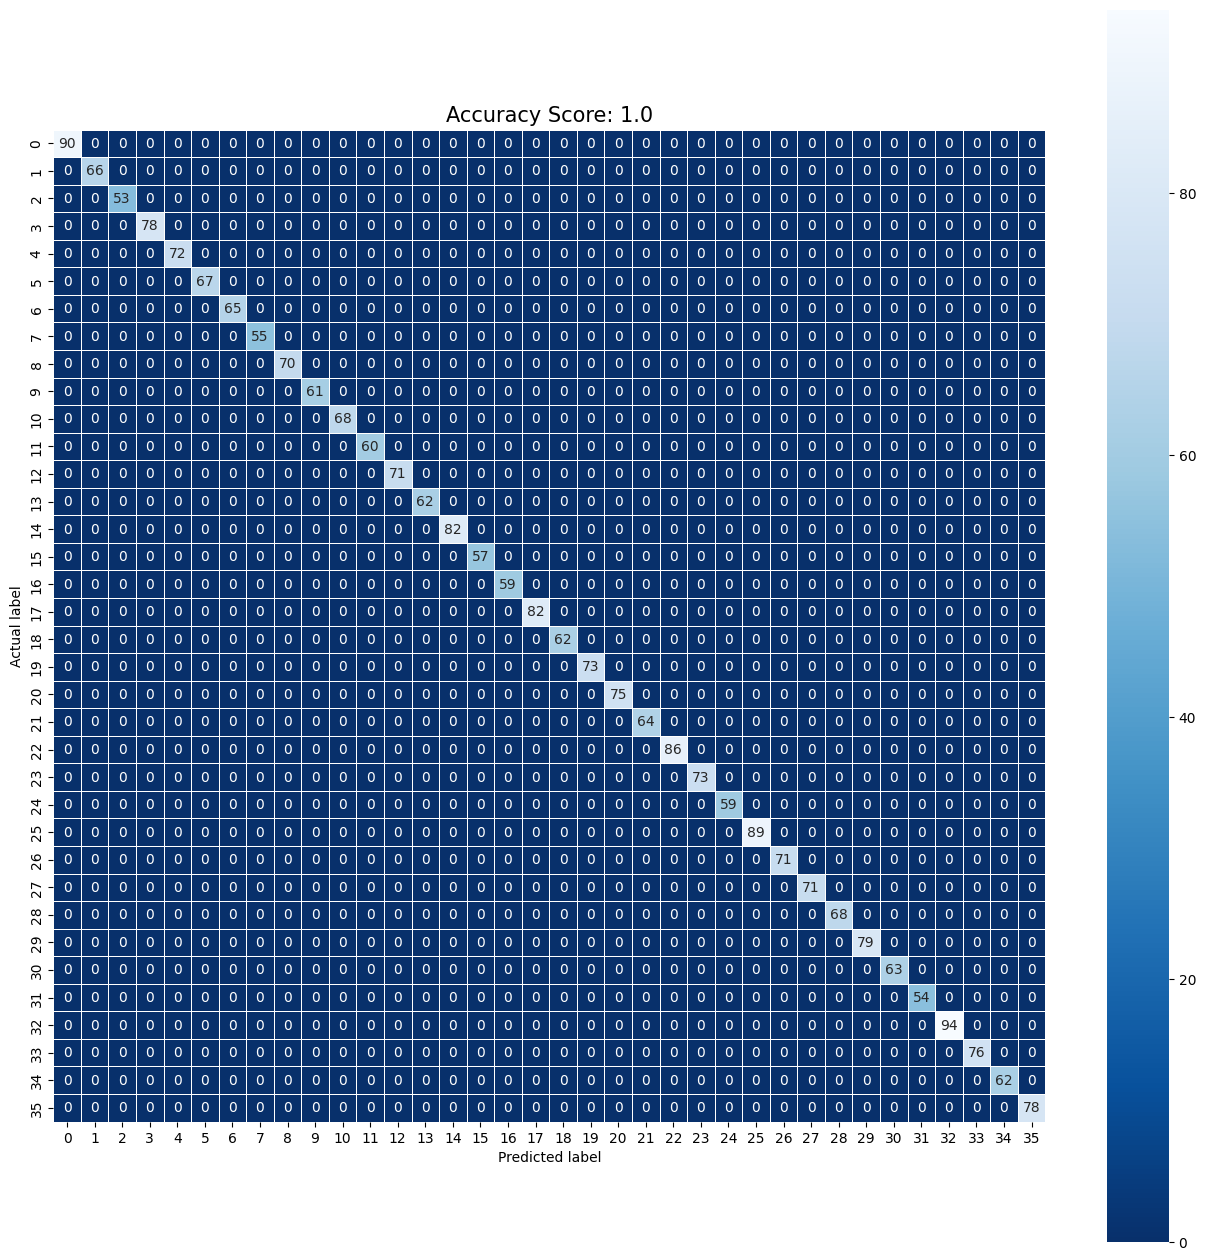

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16,16))
sns.heatmap(cm,annot=True, fmt='.0f', linewidths=.5, square=True,cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test, y_pred))
plt.title(all_sample_title,size=15)

In [ ]:
model2 = tf.keras.models.load_model("/content/drive/MyDrive/ComputerVision/ModelGrayScale")

In [ ]:
img = Image.open("/content/asl_dataset/o/hand1_o_dif_seg_3_cropped.jpeg")
img = img.resize((256,256))
img = img.rotate(72)
img = img.convert('L')
img2 = img_to_array(img)
img2 = np.array(img2, dtype=np.float16) / 255.0
img2 = img2.reshape( -1, 256,256,1)
pred = model2.predict(img2)

1/1 [==============================] - 0s 165ms/step


In [ ]:
out = lb.inverse_transform(pred)
print(out)

['a']


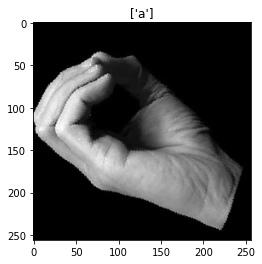

In [ ]:
out = lb.inverse_transform(pred)
plt.imshow(img, cmap='gray')
plt.title(out)
plt.show()

In [ ]:
X_test_img = []
for i in range(0, len(X_test)):
  X_test_img.append(array_to_img(X_test[i]))

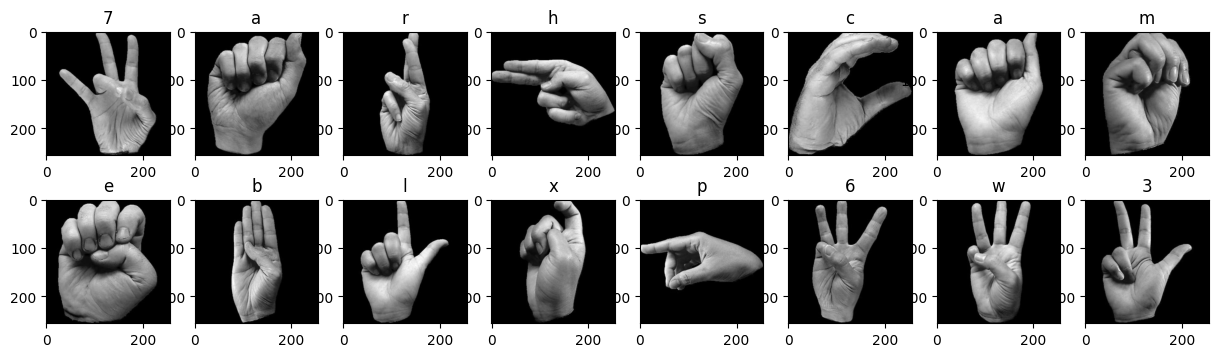

In [ ]:
fig, ax = plt.subplots(2, 8, figsize=(15,4))
ax = ax.flatten()
j = 0
for i in range(0, 16):
  ax[i].imshow(X_test_img[i], cmap='gray')
  ax[i].set_title(y_pred[i])
plt.show()

# 10 epoches

In [ ]:
images = []
labels = []
for label in os.listdir('/content/asl_dataset'):
    for file in os.listdir(f"/content/asl_dataset/{label}"):
        path = f"/content/asl_dataset/{label}/{file}"
        image = Image.open(path)
        image = image.resize((256,256))
        image = img_to_array(image)
        images.append(image)
        labels.append(label)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state = 666)

In [ ]:
X_train = np.array(X_train, dtype=np.float16) / 255.0
X_test = np.array(X_test, dtype=np.float16) / 255.0
X_train = X_train.reshape( -1, 256,256,3)
X_test = X_test.reshape( -1, 256,256,3)

In [ ]:
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=666)

In [ ]:
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), padding='same', input_shape=(256, 256, 3),activation='relu'))
model3.add(MaxPooling2D())
model3.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model3.add(MaxPooling2D())
model3.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model3.add(MaxPooling2D())
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dense(36, activation='softmax'))
model3.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 32, 32, 32)      

In [ ]:
hist3 = model3.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_data=(X_val,y_val), callbacks=[tensorboard_callback])

Epoch 1/10
51/51 [==============================] - 140s 3s/step - loss: 1.2376 - accuracy: 0.6805 - val_loss: 0.5568 - val_accuracy: 0.8263
Epoch 2/10
51/51 [==============================] - 140s 3s/step - loss: 0.2251 - accuracy: 0.9298 - val_loss: 0.3070 - val_accuracy: 0.8908
Epoch 3/10
51/51 [==============================] - 154s 3s/step - loss: 0.0711 - accuracy: 0.9782 - val_loss: 0.2219 - val_accuracy: 0.9380
Epoch 4/10
51/51 [==============================] - 141s 3s/step - loss: 0.0408 - accuracy: 0.9882 - val_loss: 0.1810 - val_accuracy: 0.9504
Epoch 5/10
51/51 [==============================] - 138s 3s/step - loss: 0.0452 - accuracy: 0.9913 - val_loss: 0.2098 - val_accuracy: 0.9454
Epoch 6/10
51/51 [==============================] - 142s 3s/step - loss: 0.0195 - accuracy: 0.9944 - val_loss: 0.1542 - val_accuracy: 0.9553
Epoch 7/10
51/51 [==============================] - 143s 3s/step - loss: 0.0089 - accuracy: 0.9975 - val_loss: 0.1836 - val_accuracy: 0.9504
Epoch 8/10
51

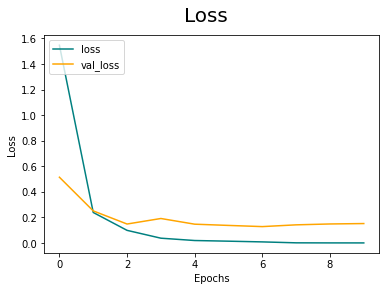

In [ ]:
fig = plt.figure()
plt.plot(hist3.history['loss'], color='teal', label='loss')
plt.plot(hist3.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

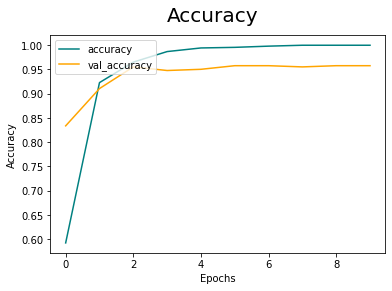

In [ ]:
fig = plt.figure()
plt.plot(hist3.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist3.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

In [ ]:
model3.evaluate(X_test, y_test)

16/16 [==============================] - 26s 2s/step - loss: 0.1913 - accuracy: 0.9503


[0.19129762053489685, 0.9502981901168823]

In [ ]:
model3.save("/content/drive/MyDrive/ComputerVision/Model10Epochs")

In [ ]:
y_pred = model3.predict(X_test)
y_pred = lb.inverse_transform(y_pred)
y_test = lb.inverse_transform(y_test)
accuracy_score(y_test, y_pred)

16/16 [==============================] - 20s 1s/step


0.9681908548707754

Text(0.5, 1.0, 'Accuracy Score: 0.9681908548707754')

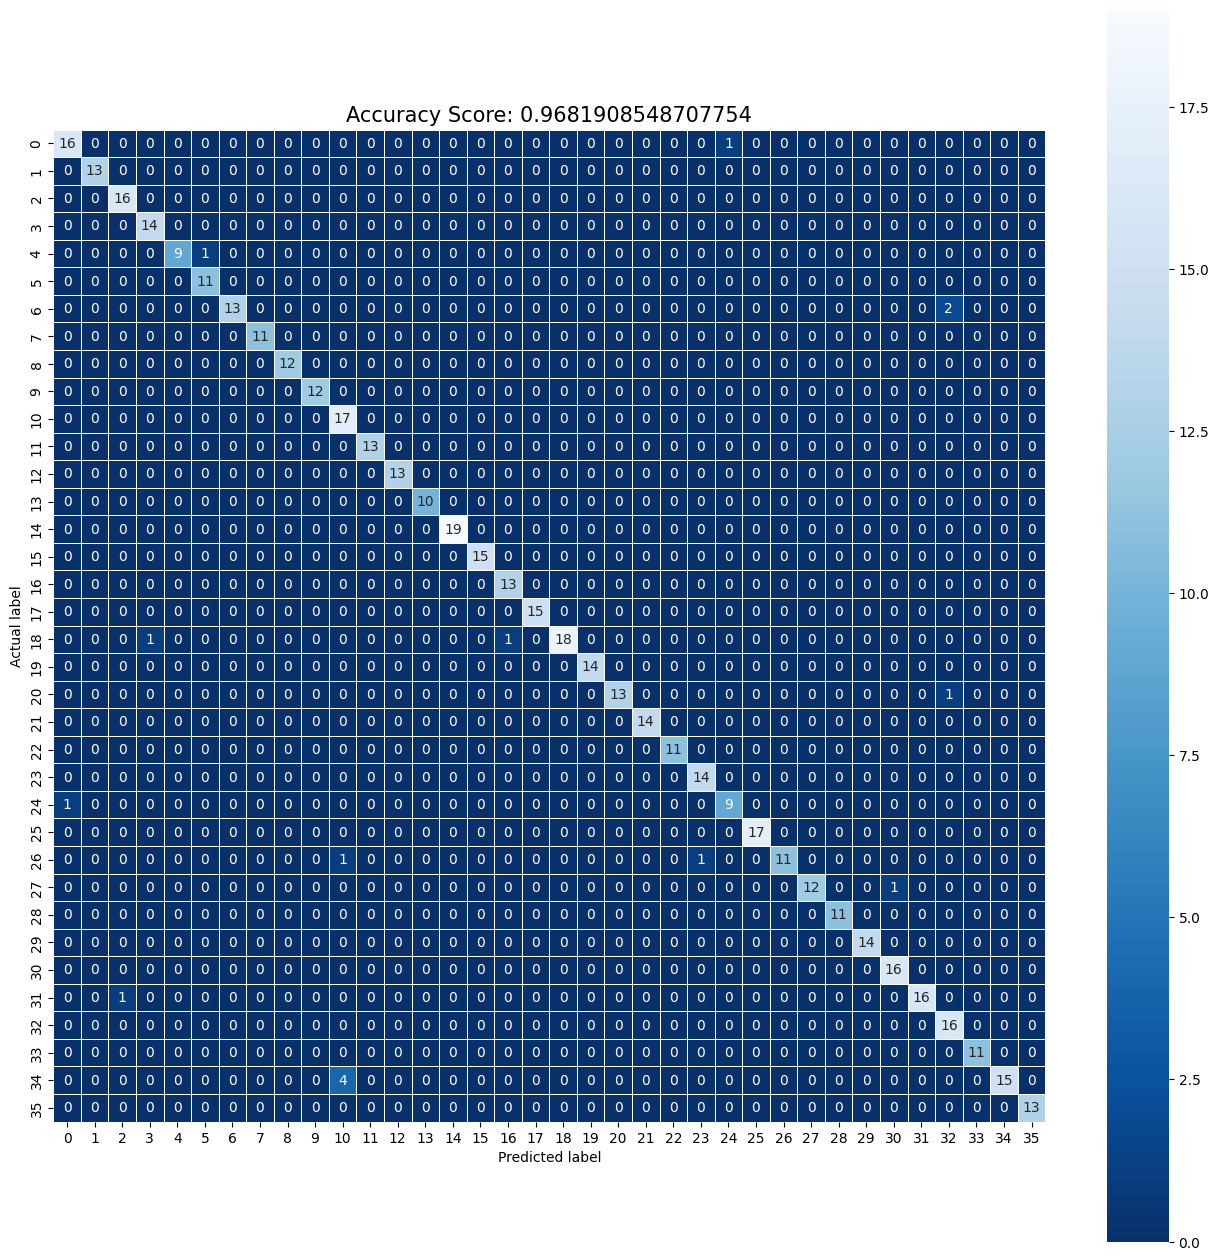

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16,16))
sns.heatmap(cm,annot=True, fmt='.0f', linewidths=.5, square=True,cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test, y_pred))
plt.title(all_sample_title,size=15)

In [ ]:
model3 = tf.keras.models.load_model("/content/drive/MyDrive/ComputerVision/Model10Epochs")

In [ ]:
img = Image.open("/content/asl_dataset/z/hand1_z_dif_seg_3_cropped.jpeg")
img = img.resize((256,256))
img2 = img_to_array(img)
img2 = np.array(img2, dtype=np.float16) / 255.0
img2 = img2.reshape( -1, 256,256,3)
pred = model3.predict(img2)
print(pred)

1/1 [==============================] - 0s 348ms/step
[[1.5669215e-05 9.9847156e-01 4.6782452e-01 2.4018178e-03 4.4682535e-04
  7.8871344e-05 9.8414522e-01 8.9550239e-01 9.5921159e-01 6.0912347e-01
  1.1534733e-03 2.2932550e-02 6.6583735e-01 5.1065125e-03 1.9045542e-03
  9.9982482e-01 7.7146965e-01 1.5376426e-02 1.8168712e-02 3.3178330e-05
  9.7031194e-01 9.8698461e-01 8.9635926e-01 7.1057002e-05 4.1638394e-03
  7.0606358e-02 6.1908290e-06 9.9999785e-01 5.1910814e-07 2.3973673e-03
  9.9894691e-01 4.7710580e-01 6.0354483e-01 5.6845024e-03 2.8032461e-01
  1.0000000e+00]]


In [ ]:
out = lb.inverse_transform(pred)

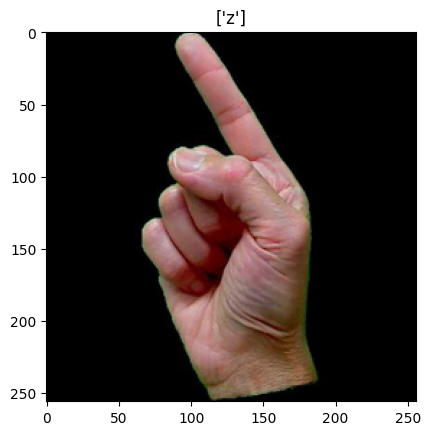

In [ ]:
plt.imshow(img)
plt.title(out)
plt.show()

In [ ]:
X_test_img = []
for i in range(0, len(X_test)):
  X_test_img.append(array_to_img(X_test[i]))

In [ ]:
X_test_img

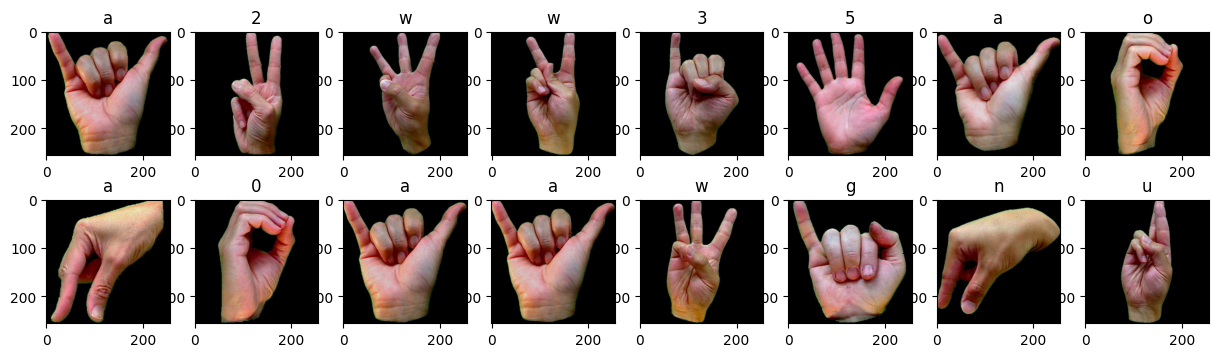

In [ ]:
fig, ax = plt.subplots(2, 8, figsize=(15,4))
ax = ax.flatten()
j = 0
for i in range(0, len(X_test_img)):
  if (j > 16):
    break;
  if (y_pred[i] != y_test[i]):
    ax[j].imshow(X_test_img[i])
    ax[j].set_title(y_pred[i])
    j += 1
plt.show()

# Resize to 64x64

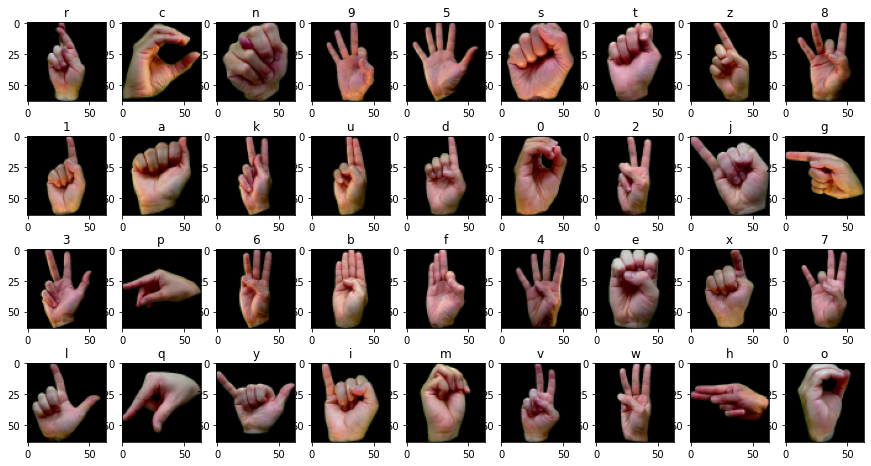

In [ ]:
fig, ax = plt.subplots(4, 9, figsize=(15,8))
labels = [os.path.join('/content/asl_dataset', label) for label in os.listdir('/content/asl_dataset')]
ax = ax.flatten()
for i, label in enumerate(labels):
    img = os.listdir(label)[np.random.randint(0, 10)]
    path = os.path.join(label, img)
    image = cv2.imread(path)
    scale_percent = 64/400
    width = int(image.shape[1] * scale_percent)
    height = int(image.shape[0] * scale_percent)
    dim = (width, height)
    image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].set_title(os.path.basename(label))
plt.show()

In [ ]:
images = []
labels = []
for label in os.listdir('/content/asl_dataset'):
    for file in os.listdir(f"/content/asl_dataset/{label}"):
        path = f"/content/asl_dataset/{label}/{file}"
        image = Image.open(path)
        image = image.resize((64,64))
        image = img_to_array(image)
        images.append(image)
        labels.append(label)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state = 666)

In [ ]:
X_train = np.array(X_train, dtype=np.float16) / 255.0
X_test = np.array(X_test, dtype=np.float16) / 255.0
X_train = X_train.reshape( -1, 64,64,3)
X_test = X_test.reshape( -1, 64,64,3)

In [ ]:
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=666)

In [ ]:
model4 = Sequential()
model4.add(Conv2D(32, (3, 3), padding='same', input_shape=(64, 64, 3),activation='relu'))
model4.add(MaxPooling2D())
model4.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model4.add(MaxPooling2D())
model4.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model4.add(MaxPooling2D())
model4.add(Flatten())
model4.add(Dense(64, activation='relu'))
model4.add(Dense(36, activation='softmax'))
model4.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 32)        

In [ ]:
hist4 = model4.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_data=(X_val,y_val), callbacks=[tensorboard_callback])

Epoch 1/10
51/51 [==============================] - 11s 202ms/step - loss: 2.7475 - accuracy: 0.2536 - val_loss: 1.3459 - val_accuracy: 0.5906
Epoch 2/10
51/51 [==============================] - 8s 155ms/step - loss: 0.8269 - accuracy: 0.7452 - val_loss: 0.6717 - val_accuracy: 0.7891
Epoch 3/10
51/51 [==============================] - 9s 180ms/step - loss: 0.4269 - accuracy: 0.8658 - val_loss: 0.3831 - val_accuracy: 0.8734
Epoch 4/10
51/51 [==============================] - 9s 180ms/step - loss: 0.2391 - accuracy: 0.9167 - val_loss: 0.3899 - val_accuracy: 0.8809
Epoch 5/10
51/51 [==============================] - 8s 154ms/step - loss: 0.1672 - accuracy: 0.9378 - val_loss: 0.2575 - val_accuracy: 0.8908
Epoch 6/10
51/51 [==============================] - 9s 181ms/step - loss: 0.1480 - accuracy: 0.9497 - val_loss: 0.1909 - val_accuracy: 0.9404
Epoch 7/10
51/51 [==============================] - 9s 178ms/step - loss: 0.0756 - accuracy: 0.9733 - val_loss: 0.2917 - val_accuracy: 0.9007
Epoch

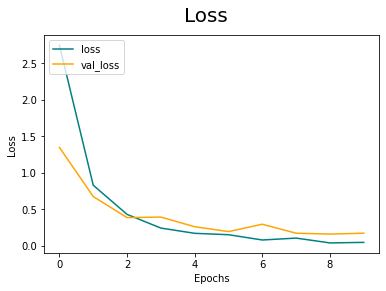

In [ ]:
fig = plt.figure()
plt.plot(hist4.history['loss'], color='teal', label='loss')
plt.plot(hist4.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

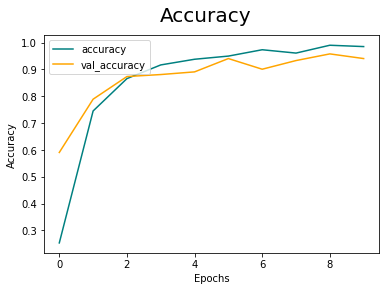

In [ ]:
fig = plt.figure()
plt.plot(hist4.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist4.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

In [ ]:
model4.evaluate(X_test, y_test)

16/16 [==============================] - 1s 63ms/step - loss: 0.2427 - accuracy: 0.9264


[0.24266809225082397, 0.9264413714408875]

In [ ]:
model4.save("/content/drive/MyDrive/ComputerVision/ModelResize")

In [ ]:
y_pred = model4.predict(X_test)
y_pred = lb.inverse_transform(y_pred)
y_test = lb.inverse_transform(y_test)
accuracy_score(y_test, y_pred)

16/16 [==============================] - 1s 55ms/step


0.9304174950298211

Text(0.5, 1.0, 'Accuracy Score: 0.9304174950298211')

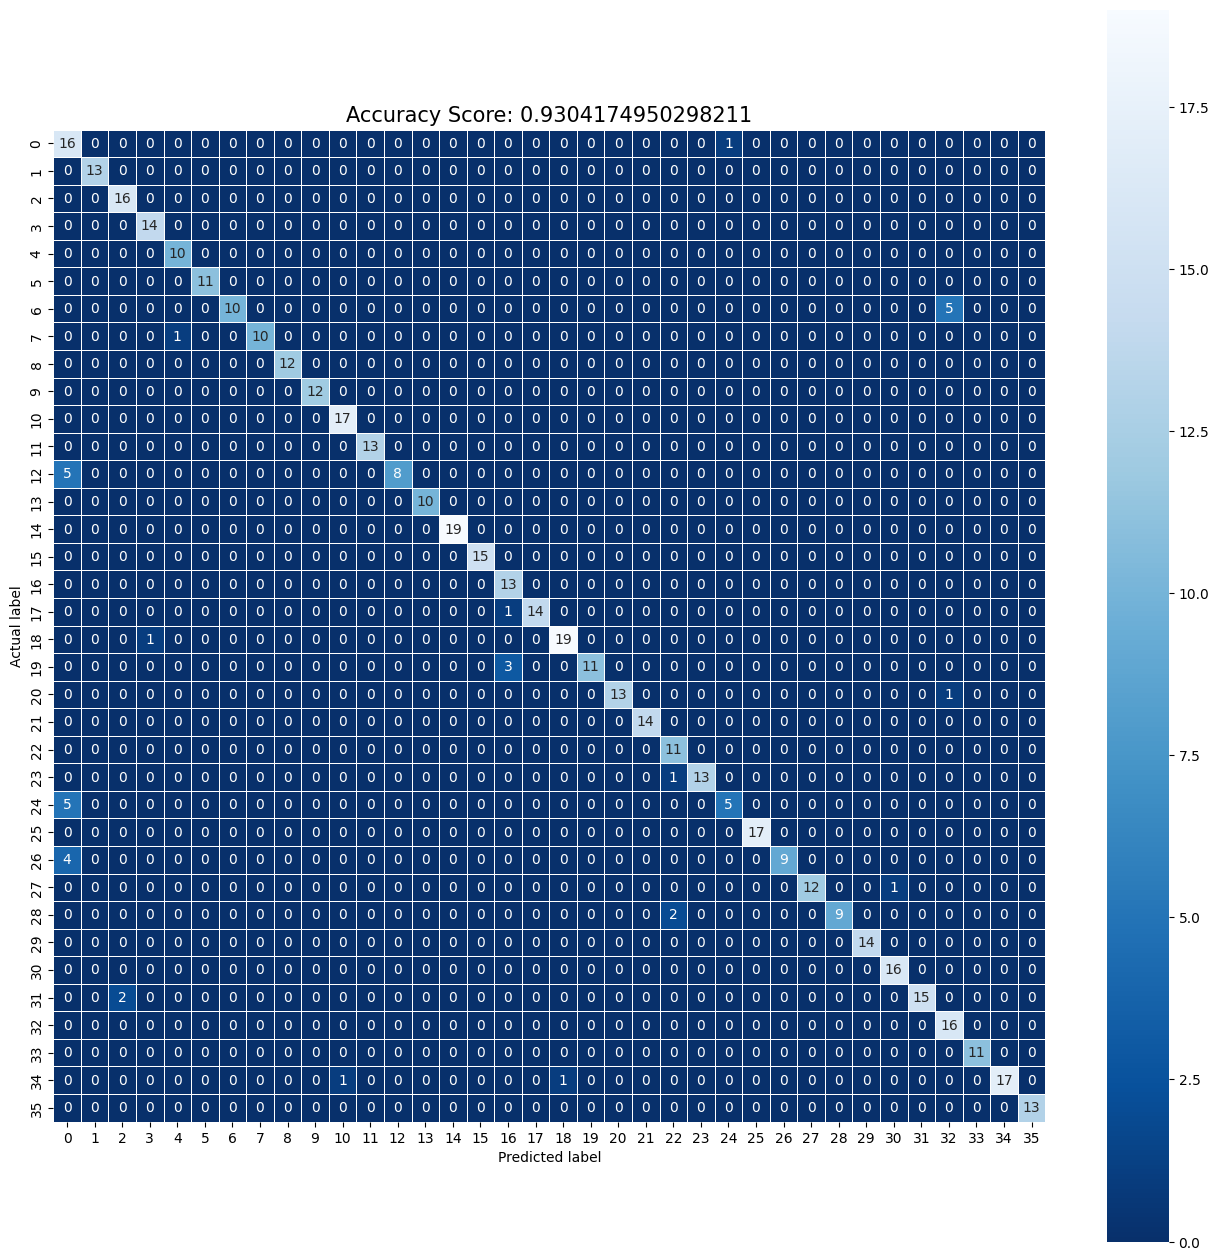

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16,16))
sns.heatmap(cm,annot=True, fmt='.0f', linewidths=.5, square=True,cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test, y_pred))
plt.title(all_sample_title,size=15)

In [ ]:
model4 = tf.keras.models.load_model("/content/drive/MyDrive/ComputerVision/ModelResize")

In [ ]:
img = Image.open("/content/asl_dataset/a/hand1_a_left_seg_1_cropped.jpeg")
img = img.resize((64,64))
img2 = img_to_array(img)
img2 = np.array(img2, dtype=np.float16) / 255.0
img2 = img2.reshape( -1, 64,64,3)
pred = model4.predict(img2)
print(pred)

1/1 [==============================] - 0s 115ms/step
[[8.9383310e-01 1.2417393e-01 3.8323782e-02 9.5630819e-01 8.1232721e-01
  9.9955022e-01 1.0325755e-02 6.3701654e-03 1.9396777e-01 4.0632533e-04
  1.0000000e+00 3.0786341e-01 1.0975394e-04 1.3702142e-01 9.9890584e-01
  9.9680412e-01 4.6258575e-01 4.6272515e-07 1.0902544e-03 9.9736369e-01
  7.6044379e-03 4.3762431e-02 9.9999851e-01 9.9941409e-01 9.1372055e-01
  9.9866736e-01 2.2136770e-05 1.0194470e-02 9.9976474e-01 9.9999893e-01
  5.8574186e-09 1.5631156e-05 4.1489903e-02 1.2032209e-01 9.5409477e-01
  9.1483456e-01]]


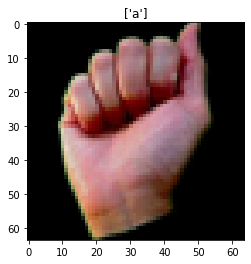

In [ ]:
out = lb.inverse_transform(pred)
plt.imshow(img)
plt.title(out)
plt.show()

In [ ]:
X_test_img = []
for i in range(0, len(X_test)):
  X_test_img.append(array_to_img(X_test[i]))

35


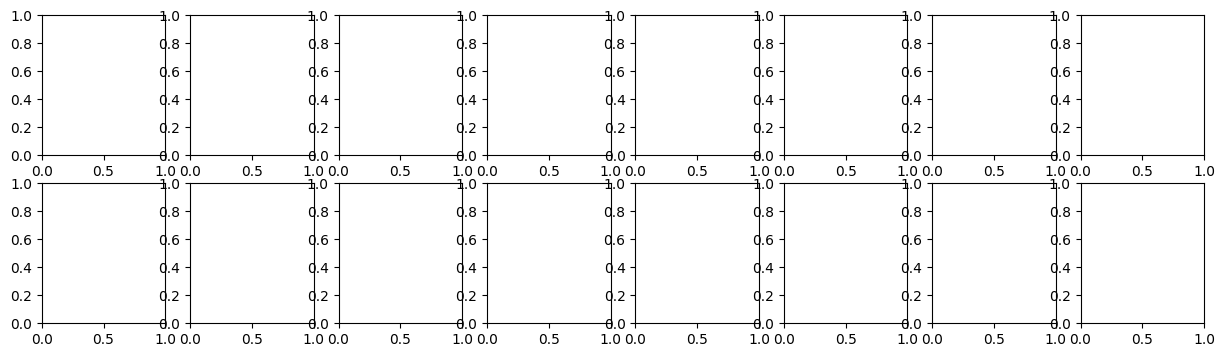

In [ ]:
fig, ax = plt.subplots(2, 8, figsize=(15,4))
ax = ax.flatten()
j = 0
for i in range(0, len(X_test_img)):
  if (y_pred[i] != y_test[i]):
    j += 1
print(j)

# Resize to 64x64 + Grayscale + Rotation

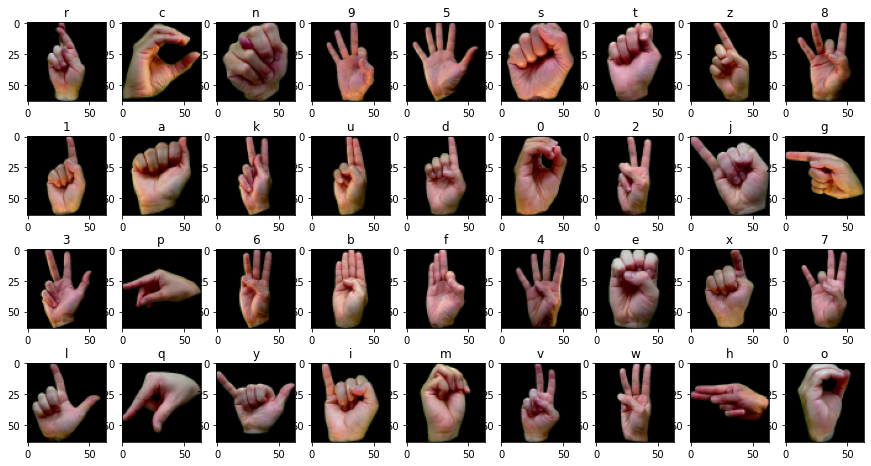

In [ ]:
fig, ax = plt.subplots(4, 9, figsize=(15,8))
labels = [os.path.join('/content/asl_dataset', label) for label in os.listdir('/content/asl_dataset')]
ax = ax.flatten()
for i, label in enumerate(labels):
    img = os.listdir(label)[np.random.randint(0, 10)]
    path = os.path.join(label, img)
    image = cv2.imread(path)
    scale_percent = 64/400
    width = int(image.shape[1] * scale_percent)
    height = int(image.shape[0] * scale_percent)
    dim = (width, height)
    image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].set_title(os.path.basename(label))
plt.show()

In [ ]:
import random
images = []
labels = []
for label in os.listdir('/content/asl_dataset'):
    for file in os.listdir(f"/content/asl_dataset/{label}"):
        path = f"/content/asl_dataset/{label}/{file}"
        image = Image.open(path)
        image2 = image.rotate(36)
        image3 = image.rotate(72)
        image4 = image.rotate(108)
        image5 = image.rotate(144)
        image = image.convert('L')
        image2 = image.convert('L')
        image3 = image.convert('L')
        image4 = image.convert('L')
        image5 = image.convert('L')
        image = image.resize((64,64))
        image2 = image.resize((64,64))
        image3 = image.resize((64,64))
        image4 = image.resize((64,64))
        image5 = image.resize((64,64))
        image = img_to_array(image)
        image2 = img_to_array(image2)
        image3 = img_to_array(image3)
        image4 = img_to_array(image4)
        image5 = img_to_array(image5)
        images.append(image)
        images.append(image2)
        images.append(image3)
        images.append(image4)
        images.append(image5)
        labels.append(label)
        labels.append(label)
        labels.append(label)
        labels.append(label)
        labels.append(label)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state = 666)

In [ ]:
X_train = np.array(X_train, dtype=np.float16) / 255.0
X_test = np.array(X_test, dtype=np.float16) / 255.0
X_train = X_train.reshape( -1, 64,64,1)
X_test = X_test.reshape( -1, 64,64,1)

In [ ]:
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=666)

In [ ]:
model5 = Sequential()
model5.add(Conv2D(32, (3, 3), padding='same', input_shape=(64, 64, 1),activation='relu'))
model5.add(MaxPooling2D())
model5.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model5.add(MaxPooling2D())
model5.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model5.add(MaxPooling2D())
model5.add(Flatten())
model5.add(Dense(64, activation='relu'))
model5.add(Dense(36, activation='softmax'))
model5.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
model5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 32)        

In [ ]:
hist5 = model5.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_data=(X_val,y_val), callbacks=[tensorboard_callback])

Epoch 1/10
252/252 [==============================] - 42s 163ms/step - loss: 0.9393 - accuracy: 0.7238 - val_loss: 0.2234 - val_accuracy: 0.9324
Epoch 2/10
252/252 [==============================] - 43s 172ms/step - loss: 0.0940 - accuracy: 0.9704 - val_loss: 0.0435 - val_accuracy: 0.9811
Epoch 3/10
252/252 [==============================] - 42s 166ms/step - loss: 0.0653 - accuracy: 0.9790 - val_loss: 0.0567 - val_accuracy: 0.9851
Epoch 4/10
252/252 [==============================] - 41s 164ms/step - loss: 0.0292 - accuracy: 0.9929 - val_loss: 0.0066 - val_accuracy: 0.9995
Epoch 5/10
252/252 [==============================] - 41s 164ms/step - loss: 0.0091 - accuracy: 0.9971 - val_loss: 0.0164 - val_accuracy: 0.9940
Epoch 6/10
252/252 [==============================] - 41s 163ms/step - loss: 0.0059 - accuracy: 0.9979 - val_loss: 0.0267 - val_accuracy: 0.9901
Epoch 7/10
252/252 [==============================] - 39s 155ms/step - loss: 0.0097 - accuracy: 0.9973 - val_loss: 0.0282 - val_ac

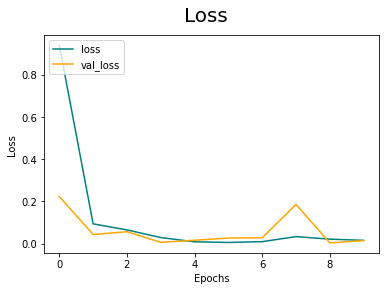

In [ ]:
fig = plt.figure()
plt.plot(hist5.history['loss'], color='teal', label='loss')
plt.plot(hist5.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

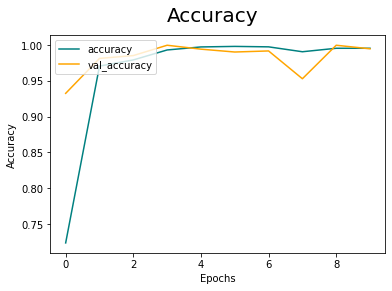

In [ ]:
fig = plt.figure()
plt.plot(hist5.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist5.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

In [ ]:
model4.evaluate(X_test, y_test)

16/16 [==============================] - 1s 36ms/step - loss: 1.4509 - accuracy: 0.6620


[1.450859785079956, 0.6620278358459473]

In [ ]:
model4.save("/content/drive/MyDrive/ComputerVision/ModelRGR")

In [ ]:
y_pred = model4.predict(X_test)
y_pred = lb.inverse_transform(y_pred)
y_test = lb.inverse_transform(y_test)
accuracy_score(y_test, y_pred)

79/79 [==============================] - 3s 37ms/step


0.8485089463220676

Text(0.5, 1.0, 'Accuracy Score: 0.8485089463220676')

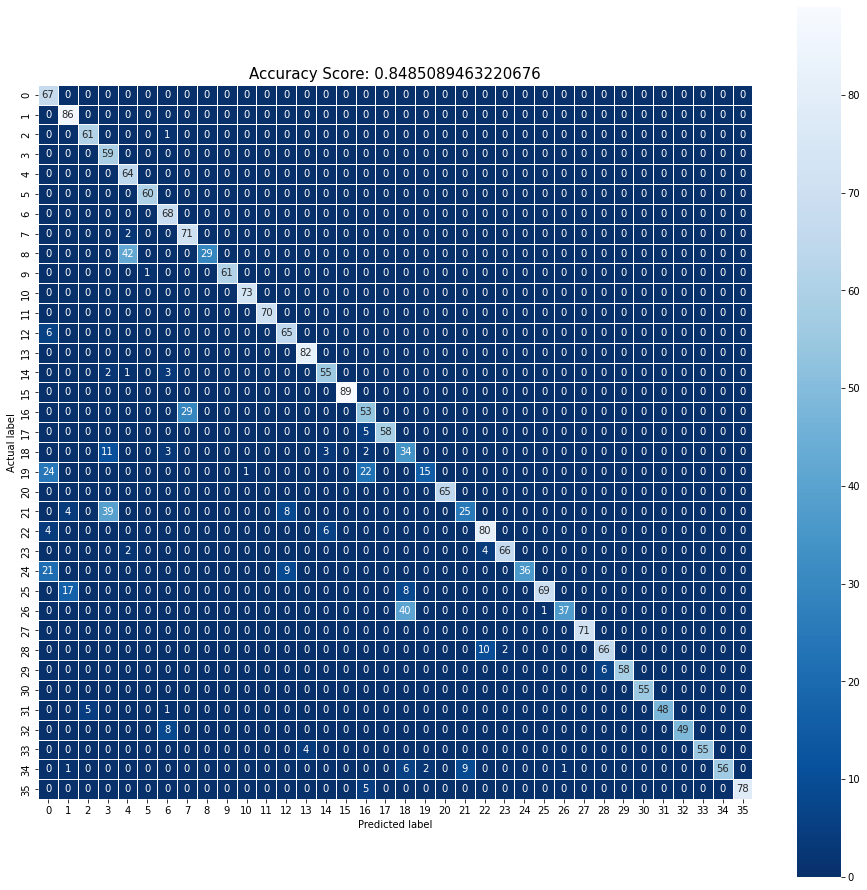

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16,16))
sns.heatmap(cm,annot=True, fmt='.0f', linewidths=.5, square=True,cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(y_test, y_pred))
plt.title(all_sample_title,size=15)